<a href="https://colab.research.google.com/github/bnwiran/tinyml-benchmark/blob/master/fine_grained_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MIT 6.S965 Fall 2022: Lab 1 Pruning**

In [ ]:
from models import utils
from metric import metric
from prune.pruner import Pruner, ChannelPruner, FineGrainedPruner
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, ToTensor
from torchvision.datasets import CIFAR10
from matplotlib import pyplot as plt
from models.models import VGG

In [ ]:
Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [ ]:
utils.set_seed(0)

In [ ]:
checkpoint = torch.load('vgg.cifar.pretrained.pth', map_location="cpu")
model = VGG()
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

In [ ]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = utils.get_sparsity(test_tensor)
    mask = FineGrainedPruner.prune_tensor(test_tensor, target_sparsity)
    sparsity_after_pruning = utils.get_sparsity(test_tensor)
    sparsity_of_mask = utils.get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

Load the pretrained model and the CIFAR-10 dataset.

In [ ]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


# Let's First Evaluate the Accuracy and Model Size of Dense Model

Neural networks have become ubiquitous in many applications. Here we have loaded a pretrained VGG model for classifying images in CIFAR10 dataset.

Let's first evaluate the accuracy and model size of this model.

In [ ]:
dense_model_accuracy = model.evaluate(dataloader['test'])
dense_model_size = utils.get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
dense model has size=35.20 MiB


While large neural networks are very powerful, their size consumes considerable storage, memory bandwidth, and computational resources.
As we can see from the results above, a model for the task as simple as classifying $32\times32$ images into 10 classes can be as large as 35 MiB.
For embedded mobile applications, these resource demands become prohibitive.

Therefore, neural network pruning is exploited to facilitates storage and transmission of mobile applications incorporating DNNs.

The goal of pruning is to reduce the model size while maintaining the accuracy.

# Let's see the distribution of weight values

Before we jump into pruning, let's see the distribution of weight values in the dense model.

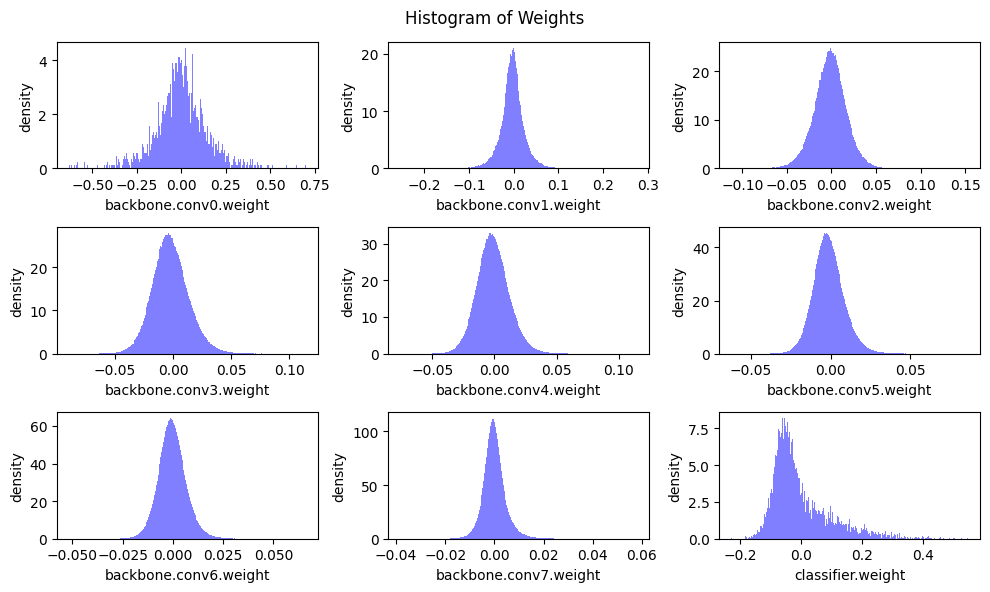

In [ ]:
utils.plot_weight_distribution(model)

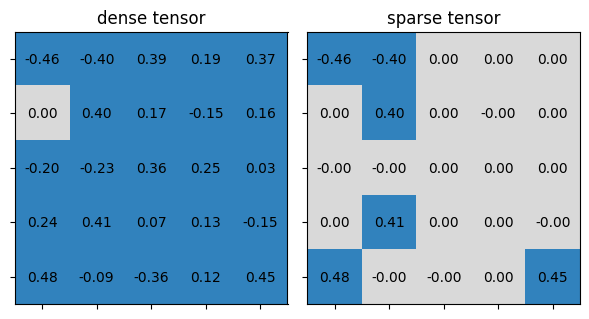

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [ ]:
test_fine_grained_prune()

### Question 3 (5 pts)

The last cell plots the tensor before and after pruning. Nonzeros are rendered in blue while zeros are rendered in gray. Please modify the value of `target_sparsity` in the following code cell so that there are only 10 nonzeros in the sparse tensor after pruning.

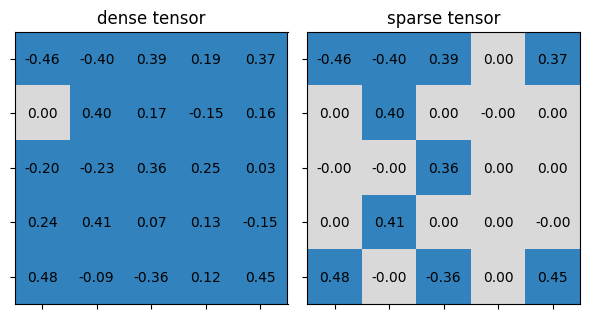

* Test fine_grained_prune()
    target sparsity: 0.60
        sparsity before pruning: 0.04
        sparsity after pruning: 0.60
        sparsity of pruning mask: 0.60
* Test passed.


In [ ]:
##################### YOUR CODE STARTS HERE #####################
target_sparsity = 15/25 # please modify the value of target_sparsity
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=10)

We now wrap the fine-grained pruning function into a class for pruning the whole model. In class `FineGrainedPruner`, we have to keep a record of the pruning masks so that we could apply the masks whenever the model weights change to make sure the model keep sparse all the time.

## Sensitivity Scan


Different layers contribute differently to the model performance. It is challenging to decide the proper sparsity for each layer. A widely used approach is sensitivity scan.

During the sensitivity scan, at each time, we will only prune one layer to see the accuracy degradation. By scanning different sparsities, we could draw the sensitivity curve (i.e., accuracy vs. sparsity) of the corresponding layer.

Here is an example figure for sensitivity curves. The x-axis is the sparsity or the percentage of #parameters dropped (*i.e.*, sparsity). The y-axis is the validation accuracy. (This is Figure 6 in [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf))


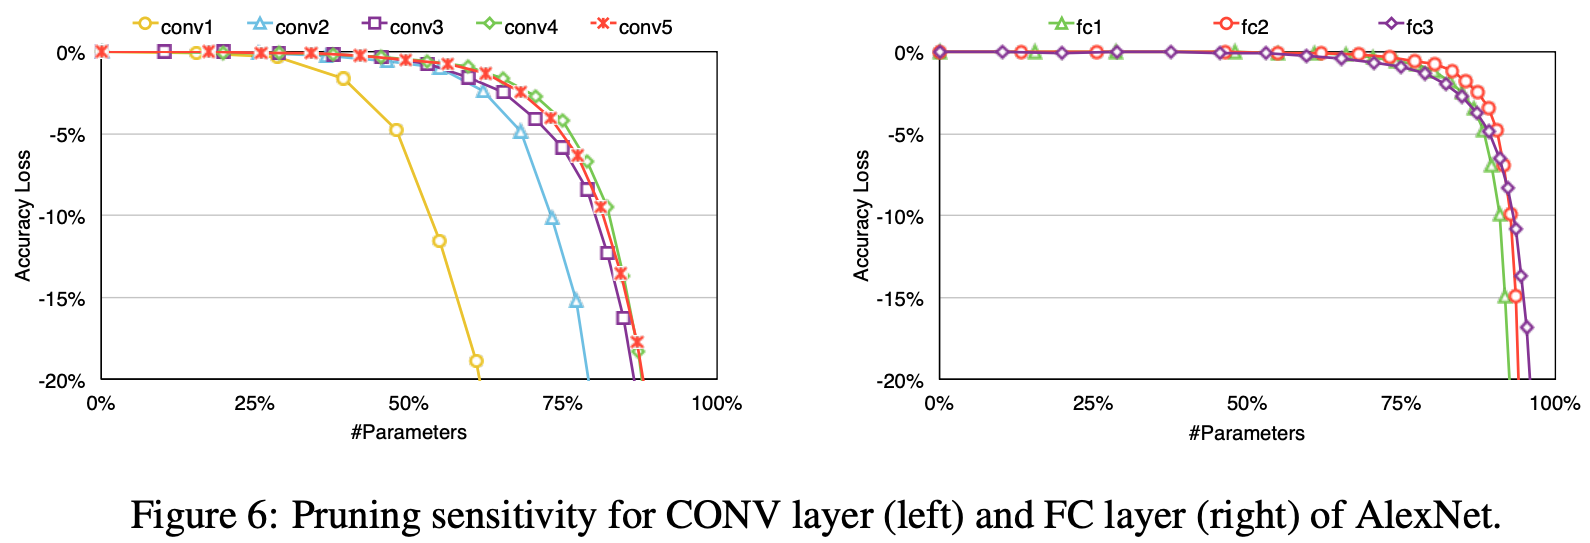

The following code cell defines the sensitivity scan function that returns the sparsities scanned, and a list of accuracies for each weight to be pruned.

Please run the following cells to plot the sensitivity curves. It should take around 2 minutes to finish.

In [ ]:
sparsities, accuracies = Pruner.sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 1/9 weight - backbone.conv0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.42%, 91.19%, 87.55%, 83.39%, 69.41%, 31.81%]

scanning 2/9 weight - backbone.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.88%, 92.71%, 92.40%, 91.32%, 84.78%]

scanning 3/9 weight - backbone.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.64%, 92.46%, 91.77%, 89.85%, 78.56%]

scanning 4/9 weight - backbone.conv3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.86%, 92.72%, 92.23%, 91.09%, 85.35%, 51.31%]

scanning 5/9 weight - backbone.conv4.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.88%, 92.68%, 92.22%, 89.47%, 76.87%, 38.78%]

scanning 6/9 weight - backbone.conv5.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.92%, 92.71%, 92.63%, 91.88%, 89.90%, 82.19%]

scanning 7/9 weight - backbone.conv6.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.86%, 92.65%, 92.10%, 90.58%, 83.65%]

scanning 8/9 weight - backbone.conv7.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.92%, 92.88%, 92.81%, 92.63%, 91.34%]

scanning 9/9 weight - classifier.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.91%, 92.83%, 92.81%, 92.97%, 92.68%, 92.52%]

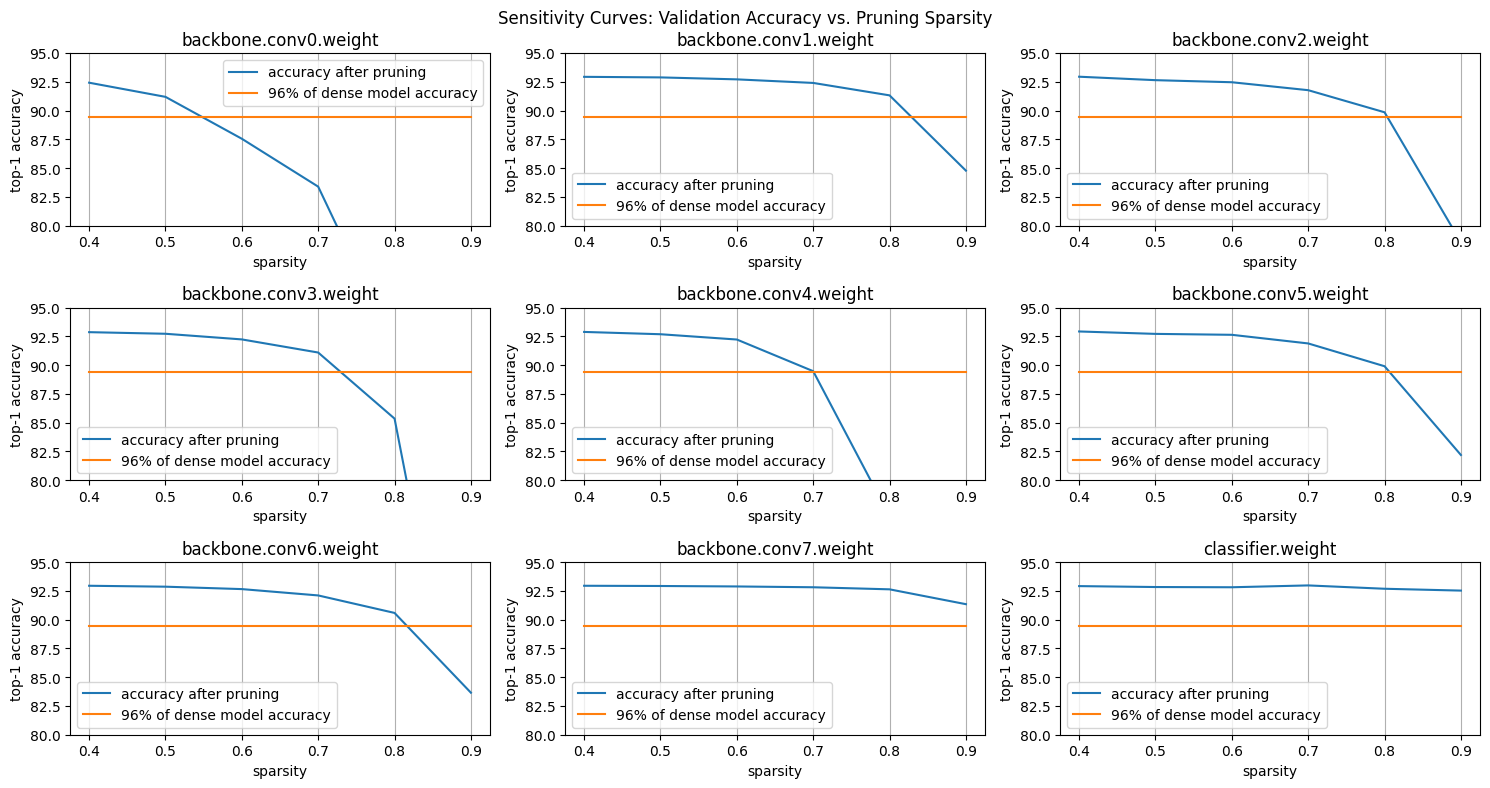

In [ ]:
Pruner.plot_sensitivity_scan(model, sparsities, accuracies, dense_model_accuracy)

## \#Parameters of each layer
In addition to accuracy, the number of each layer's parameters also affects the decision on sparsity selection. Layers with more #parameters require larger sparsities.

Please run the following code cell to plot the distribution of #parameters in the whole model.

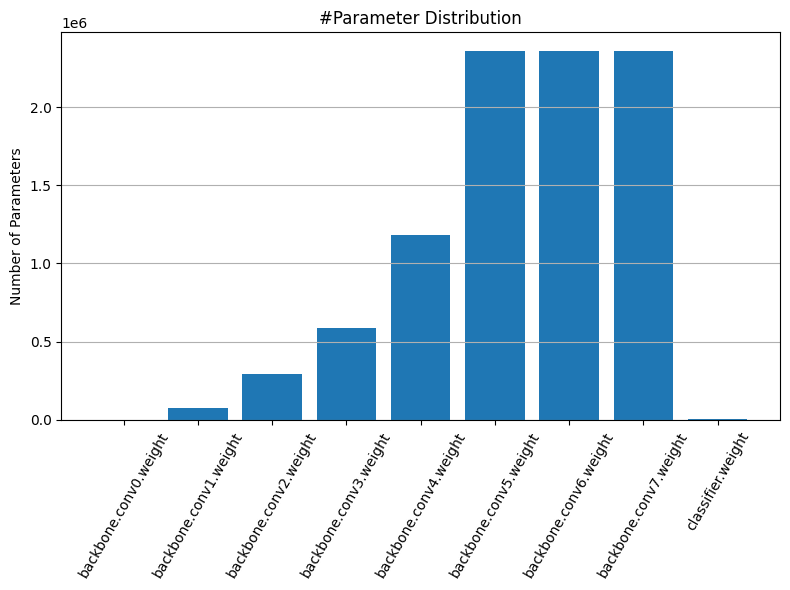

In [ ]:
utils.plot_num_parameters_distribution(model)

## Select Sparsity Based on Sensitivity Curves and \#Parameters Distribution



In [ ]:
recover_model()

sparsity_dict = {
##################### YOUR CODE STARTS HERE #####################
    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
    'backbone.conv0.weight': 0.4,
    'backbone.conv1.weight': 0.7,
    'backbone.conv2.weight': 0.6,
    'backbone.conv3.weight': 0.5,
    'backbone.conv4.weight': 0.6,
    'backbone.conv5.weight': 0.6,
    'backbone.conv6.weight': 0.7,
    'backbone.conv7.weight': 0.8,
    'classifier.weight': 0.9
##################### YOUR CODE ENDS HERE #######################
}

Please run the following cell to prune the model according to your defined `sparsity_dict`, and print the information of sparse model.

After pruning with sparsity dictionary
  backbone.conv0.weight: 0.40
  backbone.conv1.weight: 0.70
  backbone.conv2.weight: 0.60
  backbone.conv3.weight: 0.50
  backbone.conv4.weight: 0.60
  backbone.conv5.weight: 0.60
  backbone.conv6.weight: 0.70
  backbone.conv7.weight: 0.80
  classifier.weight: 0.90
The sparsity of each layer becomes
  backbone.conv0.weight: 0.40
  backbone.conv1.weight: 0.70
  backbone.conv2.weight: 0.60
  backbone.conv3.weight: 0.50
  backbone.conv4.weight: 0.60
  backbone.conv5.weight: 0.60
  backbone.conv6.weight: 0.70
  backbone.conv7.weight: 0.80
  classifier.weight: 0.90
Sparse model has size=11.59 MiB = 32.91% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=88.98% before fintuning


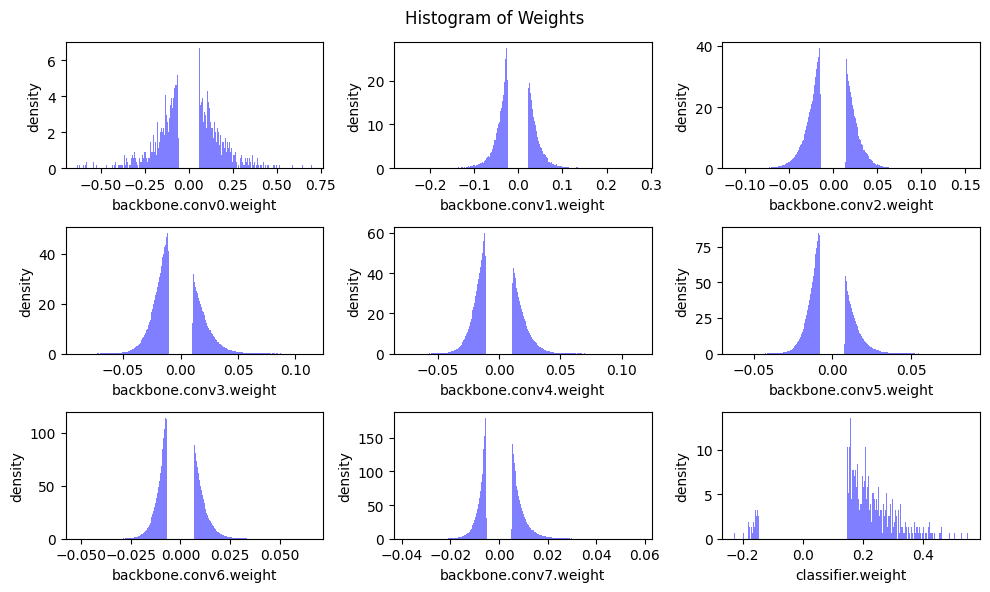

In [ ]:
FineGrainedPruner.prune(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {utils.get_sparsity(param):.2f}')

sparse_model_size = utils.get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = model.evaluate(dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

utils.plot_weight_distribution(model, count_nonzero_only=True)

## Finetune the fine-grained pruned model

As we can see from the outputs of previous cell, even though fine-grained pruning reduces the most of model weights, the accuracy of model also dropped. Therefore, we have to finetune the sparse model to recover the accuracy.

Please run the following cell to finetune the sparse model. It should take around 3 minutes to finish.

In [ ]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: FineGrainedPruner.prune(model, sparsity_dict=sparsity_dict)])
    # accuracy = evaluate(model, dataloader['test'])
    # is_best = accuracy > best_accuracy
    # if is_best:
    #     best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
    #     best_accuracy = accuracy
    # print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

In [ ]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

model.optimizer(torch.optim.SGD, lr=0.01, momentum=0.9, weight_decay=1e-4)\
.criterion(criterion).scheduler(torch.optim.lr_scheduler.CosineAnnealingLR,
                                          T_max=num_finetune_epochs)

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
model.fit(dataloader['train'], num_finetune_epochs,
          callbacks=[lambda: FineGrainedPruner.prune(model, sparsity_dict=sparsity_dict)])

# for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    # model.fit(dataloader['train'], num_finetune_epochs,
    #           callbacks=[lambda: FineGrainedPruner.prune(model)])
    # accuracy = model.evaluate(dataloader['test'])
    # is_best = accuracy > best_accuracy
    # if is_best:
    #     best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
    #     best_accuracy = accuracy
    # print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Run the following cell to see the information of best finetuned sparse model.

In [ ]:
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = utils.get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = model.evaluate(dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

# Channel Pruning

In this section, we will implement the channel pruning. Channel pruning removes an entire channel, so that it can achieve inference speed up on existing hardware like GPUs. Similarly, we remove the channels whose weights are of smaller magnitudes (measured by Frobenius norm).

In [ ]:
# firstly, let's restore the model weights to the original dense version
#   and check the validation accuracy
recover_model()
dense_model_accuracy = model.evaluate(dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

## Remove Channel Weights

Unlike fine-grained pruning, we can remove the weights entirely from the tensor in channel pruning. That is to say, the number of output channels is reduced:

> $\#\mathrm{out\_channels}_{\mathrm{new}} = \#\mathrm{out\_channels}_{\mathrm{origin}} \cdot (1 - \mathrm{sparsity})$

The weight tensor $W$ is still dense after channel pruning. Thus, we will refer to *sparsity* as ***prune ratio***.

Like fine-grained pruning, we can use different pruning rates for different layers. However, we use a uniform pruning rate for all the layers for now. We are targeting 2x computation reduction, which is roughly 30% uniform pruning rate (think about why).

Feel free to try out different pruning ratios per layer at the end of this section. You can pass in a list of ratios to the `channel_prune` function.

### Question 6 (10 pts)

Please complete the following functions for channel pruning.

Here we naively prune all output channels other than the first $\#\mathrm{out\_channels}_{\mathrm{new}}$ channels.

In [ ]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    ##################### YOUR CODE STARTS HERE #####################
    return int(round(channels * (1 - prune_ratio)))
    ##################### YOUR CODE ENDS HERE #####################

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep])
        ##################### YOUR CODE ENDS HERE #####################

    return model


Run the following cell to perform a sanity check to make sure the implementation is correct.

In [ ]:
from torch.nn import  Module, Conv2d, BatchNorm2d

In [ ]:
@torch.no_grad()
def prune(model, prune_ratio: Union[List, float]) -> Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)

    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = ChannelPruner.get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep])

    return model

In [ ]:
dummy_input = torch.randn(1, 3, 32, 32).cuda()
pruned_model = prune(model, prune_ratio=0.3)
pruned_macs = utils.get_model_macs(pruned_model, dummy_input)
assert pruned_macs == 305388064
print('* Check passed. Right MACs for the pruned model.')

Now let's evaluate the performance of the model after uniform channel pruning with 30% pruning rate.

As you may see, directly removing 30% of the channels leads to low accuracy.

In [ ]:
pruned_model_accuracy = model.evaluate(dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

## Ranking Channels by Importance

As you can see, removing the first 30% of channels in all layers leads to significant accuracy reduction. One potential method to remedy the issue is to find the **less important** channel weights to remove. A popular criterion for importance is to use the Frobenius norm of the weights corresponding to each input channel:

> $importance_{i} = \|W_{i}\|_2, \;\; i = 0, 1, 2,\cdots, \#\mathrm{in\_channels}-1$

We can sort the channel weights from more important to less important, and then keep the frst $k$ channels for each layer.

### Question 7 (15 pts)
Please complete the following functions for sorting the weight tensor based on the Frobenius norm.

**Hint**:
* To calculate Frobenius norm of a tensor, Pytorch provides [`torch.norm`](https://pytorch.org/docs/master/generated/torch.norm.html?highlight=torch+norm#torch.norm) APIs.

In [ ]:
# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(in_channels):
        channel_weight = weight.detach()[:, i_c]
        ##################### YOUR CODE STARTS HERE #####################
        importance = torch.norm(channel_weight)
        ##################### YOUR CODE ENDS HERE #####################
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)  # do not modify the original model
    # fetch all the conv and bn layers from the backbone
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the previous BN layer
        # - the input dimension of the next conv (we compute importance here)
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        # note that we always compute the importance according to input channels
        importance = get_input_channel_importance(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )

        # apply to the next conv input (hint: one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.copy_(torch.index_select(
            next_conv.weight.detach(), 1, sort_idx))
        ##################### YOUR CODE ENDS HERE #####################

    return model

Now run the following cell to sanity check if the results are correct.

In [ ]:
print('Before sorting...')
dense_model_accuracy = model.evaluate(dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = apply_channel_sorting(model)
sorted_model_accuracy = model.evaluate(dataloader['test'])
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting, since it is
# equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

Finally, we compare the pruned models' accuracy with and without sorting.

In [ ]:
@torch.no_grad()
def prune(model: Module, prune_ratio: Union[List, float]) -> Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)

    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = ChannelPruner.get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep])

    return model

In [ ]:
channel_pruning_ratio = 0.3  # pruned-out ratio

print(" * Without sorting...")
pruned_model = prune(model, channel_pruning_ratio)
pruned_model_accuracy = model.evaluate(dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = pruned_model.evaluate(dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


As you can see, the channel sorting can slightly improve the pruned model's accuracy, but there is still a huge degrade, which is quite common for channel pruning. But luckily, we can perform fine-tuning to recover the accuracy.

In [ ]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = pruned_model.evaluate(dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

## Measure acceleration from pruning

After fine-tuning, the model almost recovers the accuracy. You may have already learned that channel pruning is usually more difficult to recover accuracy compared to fine-grained pruning. However, it directly leads to a smaller model size and smaller computation without specialized model format. It can also run faster on GPUs. Now we compare the model size, computation, and latency of the pruned model.

In [ ]:
import time

In [ ]:
# helper functions to measure latency of a regular PyTorch models.
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
# @torch.no_grad()
# def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
#     model.eval()
#     # warmup
#     for _ in range(n_warmup):
#         _ = model(dummy_input)
#     # real test
#     t1 = time.time()
#     for _ in range(n_test):
#         _ = model(dummy_input)
#     t2 = time.time()
#     return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = metric.measure_latency(pruned_model, dummy_input)
original_latency = metric.measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = utils.get_model_macs(model, dummy_input)
pruned_macs = utils.get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = utils.get_num_parameters(model)
pruned_param = utils.get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

# 4. measure the model size (MiB)
original_size = utils.get_model_size(model)
pruned_size = utils.get_model_size(pruned_model)
print(table_template.format('Size (MiB)',
                            round(original_size / 1e6, 2),
                            round(pruned_size / 1e6, 2),
                            round(original_size / pruned_size, 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

### Question 8 (10 pts)

Please answer the following questions using the information in the previous code cell.


#### Question 8.1 (5 pts)

Explain why removing 30% of channels roughly leads to 50% computation reduction.

**Your Answer:**

#### Question 8.2 (5 pts)

Explain why the latency reduction ratio is slightly smaller than computation reduction.

**Your Answer:**

# Compare Fine-grained Pruning and Channel Pruning


## Question 9 (10 pts)


After all experiments in this lab, you may have become familiar with both fine-grained pruning and channel pruning.

Please answer the following questions using what you have learned from the lectures and this lab.

### Question 9.1 (5 pts)

What are the advantages and disadvantages of fine-grained pruning and channel pruning? You can discuss from the perspective of compression ratio, accuracy, latency, hardware support (*i.e.*, requiring specialized hardware accelerator), etc.

**Your Answer:**

### Question 9.2 (5 pts)

If you want to make your model run faster on a smartphone, which pruning method will you use? Why?

**Your Answer:**

# Feedback

Please fill out this [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeM7P6OU0gzcgLpQCSh-UvDIKO1hvbuk291nLLG-x-R2FPBSQ/viewform?vc=0&c=0&w=1&flr=0&usp=mail_form_link) when you finished this lab. We would love to hear your thoughts or feedback on how we can improve this lab!